# Introducción 

Rusty Bargain, un servicio dedicado a la venta de coches de segunda mano, está desarrollando una aplicación innovadora que permitirá a los usuarios conocer de manera rápida y precisa el valor de mercado de sus vehículos. Para ello, se cuenta con un conjunto de datos que incluye el historial del coche, especificaciones técnicas, versiones de equipamiento y precios. **El objetivo principal de este proyecto es diseñar un modelo de machine learning que prediga el valor de mercado con alta calidad, optimizando además la velocidad de la predicción y el tiempo requerido para el entrenamiento**. Este enfoque permitirá a Rusty Bargain ofrecer una herramienta eficiente y confiable que mejore la experiencia del usuario y facilite la toma de decisiones tanto para compradores como para vendedores.

# Inicialización

## Importación de librerías

En esta sección se realiza la inicialización e importación de las librerías necesarias para el proyecto. Se incluyen paquetes para el manejo y análisis de datos, así como funciones estadísticas específicas, modelos clásicos de machine learning y métricas de evaluación. Además, se preparan importaciones para modelos avanzados de boosting. Esta organización modular permite tener disponibles las funcionalidades requeridas para cada etapa del análisis y modelado de datos.

In [1]:
# Instalación de librerías XGBoost, CatBoost y LightGBM

#!pip install xgboost
#!pip install catboost
#!pip install lightgbm

In [2]:
# Importaciones para manejo y análisis de datos
import numpy as np
import pandas as pd
from statistics import mode

# Importaciones para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones para manipulación de tiempo y matemáticas básicas
import time

# Importaciones para preprocesamiento de datos
from sklearn.preprocessing import (StandardScaler, MaxAbsScaler, LabelEncoder)

# Importaciones para partición de datos y validación cruzada
from sklearn.model_selection import (train_test_split, GridSearchCV)

# Importaciones para modelos de Machine Learning clásicos
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Importaciones para métricas de evaluación
from sklearn.metrics import mean_squared_error

# Importaciones para modelos de boosting avanzados
#import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

/home/alexkhype/jupyter/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Carga de datos

Se carga el conjunto de datos que contiene el historial, especificaciones técnicas, versiones de equipamiento y precios de los productos. Este DataFrame servirá como base para el desarrollo del modelo predictivo de valor de mercado.

In [3]:
# Carga de datos

try:
    df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [4]:
# Información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

## Exploración inicial de datos

En el conjunto de datos se encuentra la siguiente información:

**Características**

- `DateCrawled` — fecha en la que se descargó el perfil de la base de datos
- `VehicleType` — tipo de carrocería del vehículo
- `RegistrationYear` — año de matriculación del vehículo
- `Gearbox` — tipo de caja de cambios
- `Power` — potencia (HP)
- `Model` — modelo del vehículo
- `Mileage` — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- `RegistrationMonth` — mes de matriculación del vehículo
- `FuelType` — tipo de combustible
- `Brand` — marca del vehículo
- `NotRepaired` — indica si el vehículo ha sufrido reparaciones
- `DateCreated` — fecha de creación del perfil
- `NumberOfPictures` — número de fotos del vehículo
- `PostalCode` — código postal del propietario del perfil (usuario)
- `LastSeen` — fecha de la última vez que el usuario estuvo activo

**Objetivo**
- `Price` — precio (en dólares)

El conjunto de datos contiene dos tipos de información: datos relacionados con el vehículo y datos relacionados con el usuario. Los datos asociados al usuario (`DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`) no están directamente vinculados con las características del coche ni influyen en su valoración, por lo que se excluirán del análisis. Además, aunque el mes de matriculación (`RegistrationMonth`) está relacionado con el vehículo, se optará por no incluirlo, ya que el año de matriculación proporciona suficiente información temporal para el estudio. De esta manera, el análisis se centrará únicamente en las variables que impactan directamente en la valuación del vehículo.

Asimismo, los nombres de la columnas utilizan mayúsculas. Esto dificulta la legibilidad y el mantenimiento del código, además de no seguir las convenciones comunes de nomenclatura en programación. Por ese motivo, se procederá en una etapa posterior a convertirlos a estilo `snake_case` para mejorar la claridad y consistencia. 

De esta manera, el conjunto de datos que se utilizará para el estudio queda ahora sólo con las características relevantes para la valuación del coche. Como se puede observar en la información general del conjunto, existen valores ausentes.

In [5]:
# Identificación de celdas vacías
def resaltar_nan(valor):
    color = 'red' if pd.isnull(valor) else ''
    return f'color: {color}'

# Muestra de las primeras filas
df.head().style.applymap(resaltar_nan)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,nan,1993,manual,0,golf,150000,0,petrol,volkswagen,nan,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,nan,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Los valores ausentes se encontraron solamente en cinco variables, todas ellas categóricas. Estos se tratarán posteriormente para asegurar la calidad y precisión del análisis.

In [6]:
# Conteo de observaciones duplicadas
print('Total de observaciones duplicadas:', df.duplicated().sum())

Total de observaciones duplicadas: 262


Asimismo, se encontró un total de 262 observaciones duplicadas. Estas también se tratarán posteriormente.

### Hallazgos de la sección

Como conclusión de la exploración preliminar del conjunto de datos, se identificó que, tras una selección cuidadosa de las características relevantes para el valor de los vehículos, el dataset se redujo de 16 a 10 columnas manteniendo las 354,369 observaciones originales.

Durante el análisis exploratorio se detectaron varios aspectos que requieren atención para asegurar la calidad y coherencia del modelo: 

- es necesario estandarizar los nombres de las columnas a formato `snake_case` para mejorar la legibilidad y mantenimiento del código; 

- se identificaron 262 registros duplicados que deben eliminarse para evitar sesgos en el análisis y modelado

- hay varias columnas irrelevantes que se eliminarán

- se hallaron valores ausentes en cinco columnas que deben ser investigados para determinar su origen y la mejor estrategia de imputación o manejo

## Visualización de datos

En el conjunto de datos se encuentran variables categóricas y numéricas. Se explorarán ambas características para observar la distribución de los datos. Para ello, las variables discretas se almacenarán en `categorical_data` y las variables continuas en `numerical_data`.

### Características categóricas

In [7]:
# Almacenamiento de variables categóricas
categorical_data = df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]

# Conteo de valores únicos de cada variable
for col in categorical_data:
    print(f'{col}: {categorical_data[col].nunique()}')

VehicleType: 8
Gearbox: 2
Model: 250
FuelType: 7
Brand: 40
NotRepaired: 2


A continuación se visualizará la distribución de las variables categóricas. Cabe destacar que la variable `Model` presenta 250 valores únicos, mientras que `Brand` cuenta con 40 valores únicos. Para una visualización más clara de estas variables, se presentarán únicamente las 20 categorías con mayor frecuencia.

/tmp/ipykernel_9256/3510125851.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(filas, columnas, contador)


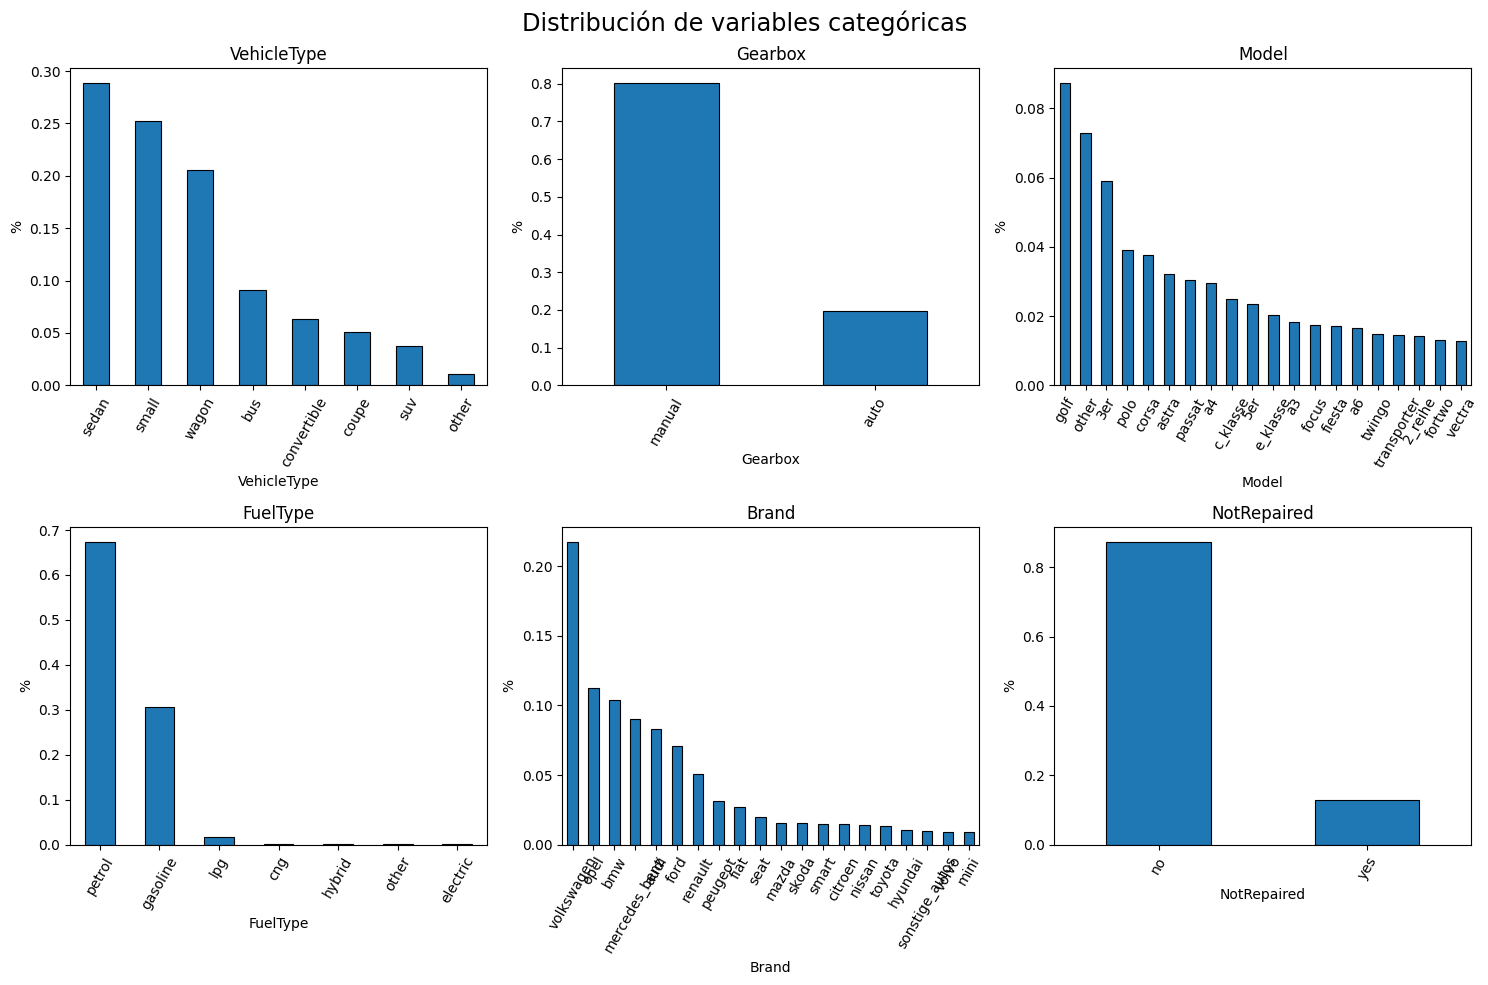

In [8]:
# Visualización de la distribución de las variables categóricas
filas = 2 
columnas = 3 
contador = 1 

fig = plt.subplots(figsize=(15, 10)) 

for i in categorical_data:
    plt.subplot(filas, columnas, contador) 
    plt.title(i)
    plt.ylabel('%')
    df[i].value_counts(normalize=True).head(20).plot(kind='bar', title=i, rot=60, edgecolor = 'black', linewidth = 0.8)
    contador += 1

plt.suptitle('Distribución de variables categóricas', fontsize='xx-large')
plt.tight_layout()
plt.show()

- Al revisar los tipos de vehículos, se identifican ocho, predominando el tipo sedán con aproximadamente un 30%. En cuanto al tipo de caja, se registran dos categorías: manual y automática, siendo la transmisión manual la más frecuente con cerca del 80%. Respecto al modelo, más del 80% corresponde al modelo Golf, dentro de un total de 250 modelos registrados. 

- En relación al tipo de combustible, se observa que casi del 70% de vehículos utilizar "petrol", mientras que alrededor del 30% utiliza "gasoline". En realidad, estas dos categorías deben unificarse, puesto que "petrol" es el nombre que se utiliza en el Reino Unido para referirse a la gasolina.

- Las marcas con mayor presencia son Volkswagen (más del 20%), seguida de Opel (más del 10%) y BMW (cerca del 10%). Finalmente, más del 80% de los vehículos presentan reparaciones, mientras que el 20% restante no.

- Cabe recordar que las características `VehicleType`, `Gearbox`, `Model`, `FuelType` y `NotRepaired` registran valores ausentes, los cuales serán analizados posteriomente. 

### Características numéricas

In [9]:
# Resumen estadístico de variables numéricas
numerical_data = df[['Price','RegistrationYear','Power','Mileage']]

numerical_data.describe().round(2)

,Price,RegistrationYear,Power,Mileage
count,354369.00,354369.00,354369.00,354369.00
mean,4416.66,2004.23,110.09,128211.17
std,4514.16,90.23,189.85,37905.34
min,0.00,1000.00,0.00,5000.00
25%,1050.00,1999.00,69.00,125000.00
50%,2700.00,2003.00,105.00,150000.00
75%,6400.00,2008.00,143.00,150000.00
max,20000.00,9999.00,20000.00,150000.00


/tmp/ipykernel_9256/4056231810.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(filas, columnas, contador)


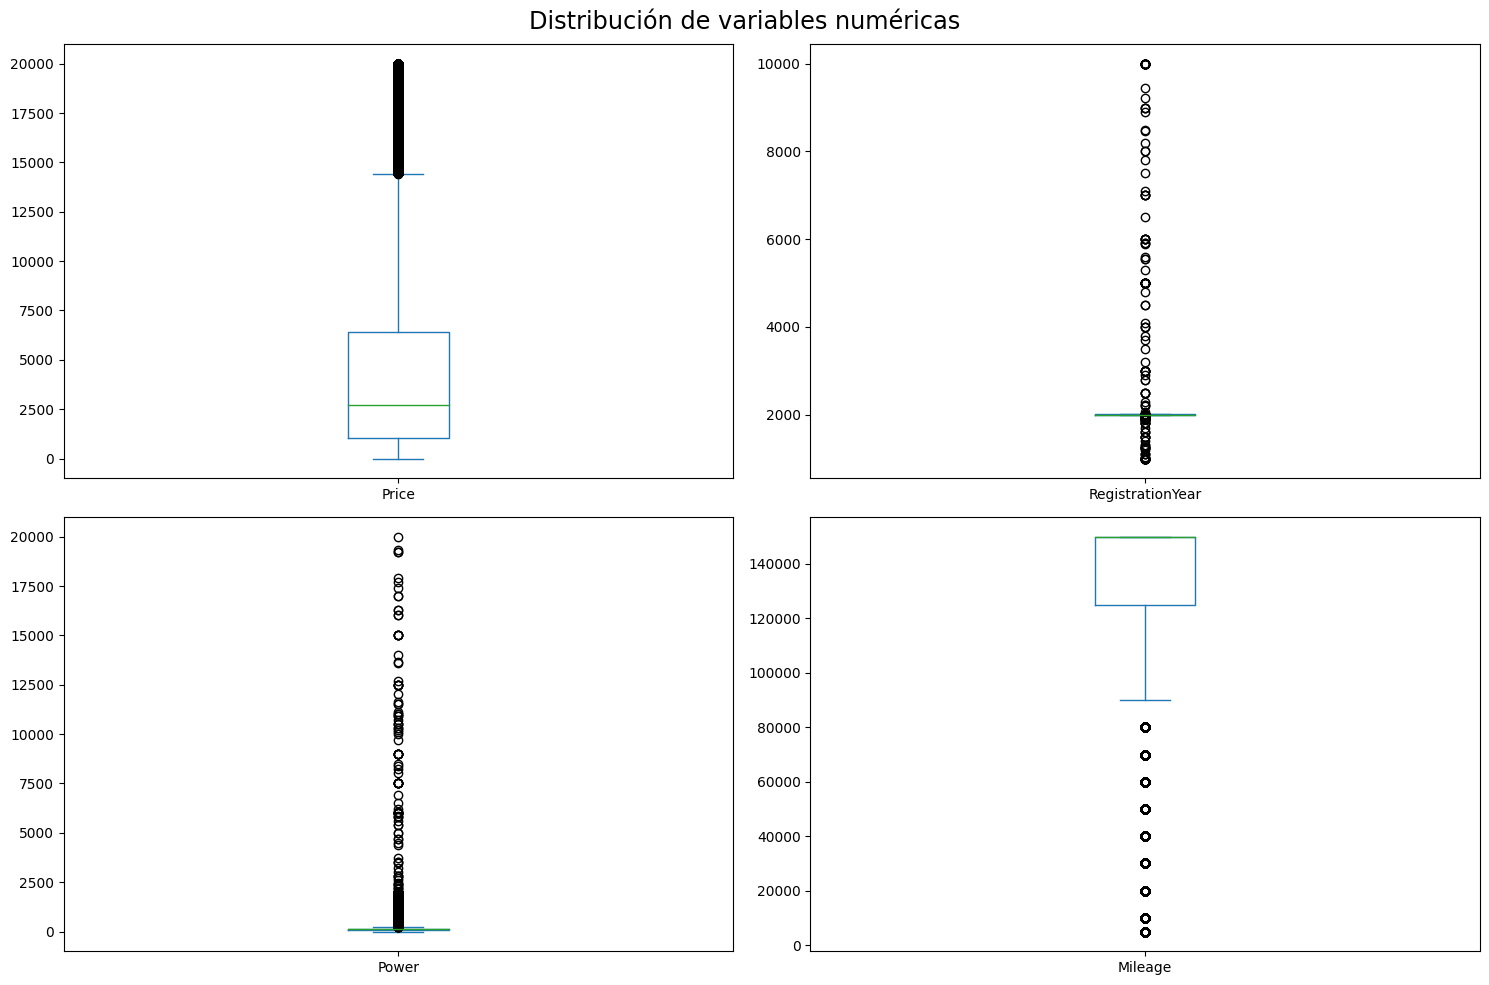

In [10]:
# Visualización de la distribución de las variables categóricas
filas = 2
columnas = 2
contador = 1

fig = plt.subplots(figsize=(15, 10))

for variable in numerical_data:
    plt.subplot(filas, columnas, contador)
    df[variable].plot(kind='box', vert=True)
    contador += 1

plt.suptitle('Distribución de variables numéricas', fontsize='xx-large')
plt.tight_layout()
plt.show()

In [11]:
# Análisis de valores atípicos en categorías numéricas

# umbral para valores atípicos (1.5 * IQR)
threshold = 1.5
outlier_stats = {}

# Cálculo de cuartiles
for col in df.select_dtypes(include=['int64']).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    
    # Cálculo de IQR
    iqr = q3 - q1
    
    # Definición de límites para valores atípicos
    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)
    
    # identificación de valores atípicos
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    # número de valores atípicos
    num_outliers = len(outliers)
    
    # porcentaje de datos
    pct_lost = (num_outliers / len(df)) * 100
    
    # actualización de diccionario
    outlier_stats[col] = {'num_outliers': num_outliers, 'pct_lost': pct_lost}

# Creación de tabla con resultados
outlier_table = pd.DataFrame.from_dict(outlier_stats, orient='index')
outlier_table.columns = ['Valores atípicos', '%']
display(outlier_table[outlier_table['Valores atípicos'] > 0].round(2))

,Valores atípicos,%
Price,18979,5.36
RegistrationYear,6309,1.78
Power,7340,2.07
Mileage,53257,15.03


- El precio promedio de los vehículos es aproximadamente \\$4,416.66, con una desviación estándar elevada de 4,514.16, lo que refleja una alta variabilidad en los precios. El rango va desde un mínimo de \\$0 hasta un máximo de $20,000. Los valores cero podrían corresponder a registros donde el vendedor no especificó el precio para que los interesados contacten directamente, por lo que es necesario tratar adecuadamente estos casos antes de construir el modelo predictivo.
  
- El año de registro promedio es 2004, con una mediana cercana en 2003. Se observa un rango muy amplio, desde 1000 hasta 9999, ambos claramente atípicos. El rango intercuartílico se sitúa entre 1999 y 2008, indicando que la mayoría de los vehículos corresponden a años modernos y realistas.
  
- La potencia promedio es 110.09 HP, con una desviación estándar alta de 189.85 y un valor máximo extremo de 20,000, lo que sugiere la presencia de valores atípicos o errores en los datos. Esto se confirma con un 2.07% de valores atípicos detectados.
  
- El kilometraje promedio es 128,211 km, con un mínimo de 5,000 y un máximo de 150,000 km. El valor de 150,000 corresponde al percentil 75 y al máximo registrado, lo que indica que podría ser un límite impuesto en la base de datos. Aunque existen valores atípicos, estos podrían representar vehículos con bajo uso.

### Conclusiones de sección

De las variables categóricas, únicamente la variable `Brand` se encuentra completa. Es necesario evaluar de forma individual la viabilidad de imputar los valores faltantes en las variables `VehicleType`, `Gearbox`, `Model`, `FuelType` y `NotRepaired` mediante técnicas adecuadas, considerando alternativas como la imputación con la categoría más frecuente o métodos basados en aprendizaje automático para evitar sesgos y pérdida de información.

Por otro lado, el análisis estadístico preliminar de las variables numéricas revela la presencia de valores atípicos y registros anómalos que requieren un tratamiento cuidadoso.

# Procesamiento de datos

## Estandarización de nombres de columnas

In [12]:
# Cambio de nombres a estilo snake_case
df.columns = df.columns.str.replace(r'([A-Z])', r'_\1', regex=True).str.strip('_').str.lower()
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

## Eliminación de observaciones duplicadas

In [13]:
# Eliminación de observaciones duplicadas
df = df.drop_duplicates().reset_index(drop=True)
print(f'Número de valores duplicados: {df.duplicated().sum()}')

Número de valores duplicados: 0


## Eliminación de características irrelevantes

In [14]:
# Eliminación de características irrelevantes
df_auto = df.drop(columns=['registration_month', 'date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'])
df_auto.info()

print(df_auto.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354107 non-null  int64 
 1   vehicle_type       316623 non-null  object
 2   registration_year  354107 non-null  int64 
 3   gearbox            334277 non-null  object
 4   power              354107 non-null  int64 
 5   model              334406 non-null  object
 6   mileage            354107 non-null  int64 
 7   fuel_type          321218 non-null  object
 8   brand              354107 non-null  object
 9   not_repaired       282962 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB
(354107, 10)


Se eliminaron las variables `'registration_month'`, `'date_crawled'`, `'date_created'`, `'number_of_pictures'`, `'postal_code'` y `'last_seen'` debido a que no influyen directamente en la determinación del precio de un vehículo. Esta decisión busca reducir el ruido en los datos y mejorar la calidad de los próximos modelos.

## Valores ausentes en variables categóricas

In [15]:
# Conteo de valores ausentes
nan_count = df_auto.isna().sum()
nan_percent = 100 * df_auto.isna().sum() / len(df_auto)
       
nan_table = pd.concat([nan_count, nan_percent], axis=1).round(2)
nan_table.columns = ['Valores ausentes', '%']

nan_table[nan_table.iloc[:,1] != 0]

,Valores ausentes,%
vehicle_type,37484,10.59
gearbox,19830,5.60
model,19701,5.56
fuel_type,32889,9.29
not_repaired,71145,20.09


Se procederá a explorar cada variable de forma individual, con el objetivo de imputar los datos faltantes en la mayor medida posible

### Gearbox

In [16]:
# Análisis de distribución relativa de la variable categórica 'gearbox'
df_auto['gearbox'].value_counts(dropna=False, normalize=True)

gearbox
manual    0.756929
auto      0.187071
NaN       0.056000
Name: proportion, dtype: float64

Para esta variable, se realizará un filtrado del conjunto de datos excluyendo aquellos registros con valores ausentes en las columnas `'gearbox'` y `'model'`. A continuación, se construirá una tabla dinámica que calcule la moda para cada combinación. Los valores faltantes en estas variables serán imputados con la moda correspondiente. En los casos en que no sea posible determinar una moda, se asignará el valor `'unknown'`.

In [17]:
# Filtrado de dataset sin valores ausentes en 'gearbox' y 'model', y creación de tabla dinámica que devuelva la moda  
gearbox_without_nan = df_auto.dropna(subset=['gearbox', 'model'])
gearbox_model = gearbox_without_nan.pivot_table(index=['brand','model'], values='gearbox', aggfunc=mode)

# Función fill_gearbox para llenado de valores faltantes usando la moda por marca y modelo
def fill_gearbox(row):
   
    model = row['model']
    gearbox = row['gearbox']
    brand = row['brand']

    if pd.isna(gearbox):
        try:
            return gearbox_model.loc[(brand, model), 'gearbox']
        except:
            return 'unknown'
    return gearbox

In [18]:
# Comprobación de funcionamiento correcto
filas = [
    ['alfa_romeo', '145', np.nan],
    ['falso', 'modelo', np.nan]
]
columnas = ['brand', 'model', 'gearbox']
prueba_df = pd.DataFrame(data=filas, columns=columnas)

prueba_df = prueba_df.apply(fill_gearbox, axis=1)
print(prueba_df)

0     manual
1    unknown
dtype: object


In [19]:
# Aplicación de la función al df
df_auto['gearbox'] = df_auto.apply(fill_gearbox, axis = 1)

# Conteo de observaciones cuyo tipo no pudo establecerse
print('Observaciones cuyo tipo no pudo establecerse:', len(df_auto.loc[df_auto['gearbox'] == 'unknown']))

Observaciones cuyo tipo no pudo establecerse: 4130


In [20]:
# Análisis de distribución relativa tras llenado
print('Valores únicos en gearbox:')
print(df_auto['gearbox'].value_counts(dropna=False, normalize=True))

Valores únicos en gearbox:
gearbox
manual     0.795759
auto       0.192577
unknown    0.011663
Name: proportion, dtype: float64


### Model

Para esta variable, se realizará un filtrado del conjunto de datos excluyendo aquellos registros con valores ausentes en las columnas `'brand'` y `'registration_year'`. A continuación, se construirá una tabla dinámica que calcule la moda para cada combinación. Los valores faltantes en estas variables serán imputados con la moda correspondiente. En los casos en que no sea posible determinar una moda, se asignará el valor `'unknown'`.

In [21]:
# Filtrado de dataset sin valores ausentes en 'model', y creación de tabla dinámica que devuelva la moda 
model_without_nan = df.dropna(subset=['model'])
model_brand = model_without_nan.pivot_table(index=['brand', 'registration_year'], values='model', aggfunc=mode)

# Función para llenado de valores faltantes
def fill_model(row):
    
    model = row['model']
    registration_year = row['registration_year']
    brand = row['brand']
    
    if pd.isna(model):
        try:
            return model_brand.loc[(brand, registration_year), 'model']
        except:
            return 'unknown'
    return model

In [22]:
# Comprobación de funcionamiento correcto
row_values = [
    ['volvo', 2013, np.nan],
    ['falso', 'modelo', np.nan]
]
row_columns = ['brand', 'registration_year', 'model']

prueba_df = pd.DataFrame(data=row_values, columns=row_columns)

prueba_df = prueba_df.apply(fill_model, axis=1)
print(prueba_df)

0        v60
1    unknown
dtype: object


In [23]:
# Aplicación de la función al df
df_auto['model'] = df_auto.apply(fill_model, axis = 1)

# Conteo de observaciones cuyo tipo no pudo establecerse
print('Observaciones cuyo tipo no pudo establecerse:', len(df_auto.loc[df_auto['model'] == 'unknown']))

Observaciones cuyo tipo no pudo establecerse: 3441


In [24]:
# Análisis de distribución relativa tras llenado
print('Valores únicos en model:')
print(df_auto['model'].value_counts(dropna=False, normalize=True))

Valores únicos en model:
model
golf                  0.092263
other                 0.073085
3er                   0.061061
corsa                 0.039186
polo                  0.036873
                        ...   
i3                    0.000023
rangerover            0.000011
serie_3               0.000011
range_rover_evoque    0.000006
serie_1               0.000006
Name: proportion, Length: 251, dtype: float64


### Vehicle Type

Para esta variable, se realizará un filtrado del conjunto de datos excluyendo aquellos registros con valores ausentes en las columnas `'brand'` y `'model'`. A continuación, se construirá una tabla dinámica que calcule la moda para cada combinación. Los valores faltantes en estas variables serán imputados con la moda correspondiente. En los casos en que no sea posible determinar una moda, se asignará el valor 'unknown'.

In [25]:
# Filtrado de dataset sin valores ausentes en 'brand' y 'model', y creación de tabla dinámica que devuelva la moda 
vehicletype_without_nan = df_auto.dropna(subset=['vehicle_type', 'model'])
vehicletype_model = vehicletype_without_nan.pivot_table(index=['brand','model'], values='vehicle_type', aggfunc=mode)

# Función para llenado de valores faltantes
def fill_vehicle_type(row):
    
    brand = row['brand']
    model = row['model']
    vehicle_type = row['vehicle_type']
    
    if pd.isna(vehicle_type):
        try:
            return vehicletype_model.loc[(brand, model), 'vehicle_type']
        except:
            return 'unknown'
    return vehicle_type

In [26]:
# Comprobación de funcionamiento correcto
row_values = [
    ['alfa_romeo', '145', np.nan],
    ['falso', 'modelo', np.nan]
]
row_columns = ['brand', 'model', 'vehicle_type']

prueba_df = pd.DataFrame(data=row_values, columns=row_columns)

prueba_df = prueba_df.apply(fill_vehicle_type, axis=1)
print(prueba_df)

0      small
1    unknown
dtype: object


In [27]:
# Aplicación de la función al df
df_auto['vehicle_type'] = df_auto.apply(fill_vehicle_type, axis = 1)

# Conteo de observaciones cuyo tipo no pudo establecerse
print('Observaciones cuyo tipo no pudo establecerse:', len(df_auto.loc[df_auto['vehicle_type'] == 'unknown']))

Observaciones cuyo tipo no pudo establecerse: 25


In [28]:
# Análisis de distribución relativa tras llenado
print('Valores únicos en vehicle_type:')
print(df_auto['vehicle_type'].value_counts(dropna=False, normalize=True))

Valores únicos en vehicle_type:
vehicle_type
sedan          0.305820
small          0.256917
wagon          0.195144
bus            0.091444
convertible    0.057782
coupe          0.047497
suv            0.035972
other          0.009353
unknown        0.000071
Name: proportion, dtype: float64


### Fuel Type

Los términos "petrol" y "gasoline" se refieren al mismo tipo de combustible, diferenciándose únicamente por su uso geográfico: "petrol" se emplea en Reino Unido e India, mientras que "gasoline" es común en Estados Unidos. Por lo tanto, resulta adecuado unificarlos en una sola categoría, ya que no representan combustibles distintos, sino denominaciones diferentes para el mismo producto. 

In [29]:
# Reemplazo de 'petrol' por 'gasoline'
df_auto['fuel_type'] = df_auto['fuel_type'].replace('petrol', 'gasoline')

# Comprobación de la nueva distribución de los datos
df_auto['fuel_type'].value_counts(dropna=False, normalize=True)

fuel_type
gasoline    0.889050
NaN         0.092879
lpg         0.014987
cng         0.001596
hybrid      0.000658
other       0.000576
electric    0.000254
Name: proportion, dtype: float64

El rellenado se realizará a partir del modelo. Dado que existen modelos clasificados como 'unknown', cuyo tipo de combustible no puede inferirse con precisión, estos se asignarán directamente con el valor 'unknown'. Para el resto de los casos, se aplicará la función correspondiente para completar el dato.

In [30]:
# Asignación de 'unknown' a observaciones cuyo 'fuel_type' y 'model' se desconocen
df_auto.loc[(df_auto['fuel_type'].isna()) & (df_auto['model'] == 'unknown'), 'fuel_type'] = 'unknown'

# Filtrado de dataset sin valores ausentes en 'fuel_type' y 'model', y creación de tabla dinámica que devuelva la moda 
fuel_without_nan = df_auto.dropna(subset=['fuel_type', 'model'])
fuel_model = fuel_without_nan.pivot_table(index=['model'], values='fuel_type', aggfunc=mode)

# Función para llenado de valores faltantes
def fill_fuel_type(row):
    
    model = row['model']
    fuel_type = row['fuel_type']
    
    if pd.isna(fuel_type):
        try:
            return fuel_model.loc[model, 'fuel_type']
        except:
            return 'unknown'
    return fuel_type

In [31]:
# Comprobación de funcionamiento correcto
row_values = [
    ['100', np.nan],
    ['falso', np.nan]
]
row_columns = ['model', 'fuel_type']
prueba_df = pd.DataFrame(data=row_values, columns=row_columns)
prueba_df = prueba_df.apply(fill_fuel_type, axis=1)
print(prueba_df)

0    gasoline
1     unknown
dtype: object


In [32]:
# Aplicación de la función al df
df_auto['fuel_type'] = df_auto.apply(fill_fuel_type, axis = 1)

# Conteo de observaciones cuyo tipo no pudo establecerse
print('Observaciones cuyo tipo no pudo establecerse:', len(df_auto.loc[df_auto['fuel_type'] == 'unknown']))

Observaciones cuyo tipo no pudo establecerse: 1144


In [33]:
# Análisis de distribución relativa tras llenado
print('Valores únicos en fuel_type:')
print(df_auto['fuel_type'].value_counts(dropna=False, normalize=True))

Valores únicos en fuel_type:
fuel_type
gasoline    0.978699
lpg         0.014987
unknown     0.003231
cng         0.001596
hybrid      0.000658
other       0.000576
electric    0.000254
Name: proportion, dtype: float64


### Not Repaired

La condición de reparación de un vehículo depende de la decisión individual de cada usuario, por lo que los valores faltantes en esta variable no pueden ser imputados a partir de otras características del conjunto de datos. Por esta razón, se desarrollará un modelo de machine learning que prediga el estado del vehículo considerando todas las variables disponibles. Para ello, se transformará la variable categórica en numérica mediante la creación de un diccionario que asigne 0 a "no" y 1 a "yes", aplicando posteriormente la función map para realizar esta sustitución.

In [34]:
# Codificación en equivalencia binaria
not_repaired_dict = {'no': 0, 'yes': 1}
df_auto['not_repaired'] = df_auto['not_repaired'].map(not_repaired_dict)

# Comprobación de cambios
df_auto['not_repaired'].value_counts(dropna=False, normalize=True)

not_repaired
0.0    0.697323
NaN    0.200914
1.0    0.101763
Name: proportion, dtype: float64

Se construirá un modelo de regresión logística para predecir si un vehículo ha sido reparado, utilizando dichas predicciones para imputar los valores ausentes. Para ello, se utilizará LabelEncoder para las variables con alta cardinalidad, mientras que las se baja cardinalidad serán codificadas mediante One-Hot Encoding.

In [35]:
# Codificación para resultados óptimos
df_coded = df_auto.copy()

# LabelEncoder para características con alta cardinalidad
le = LabelEncoder()
df_coded['model_encoded'] = le.fit_transform(df_coded['model'])
df_coded['brand_encoded'] = le.fit_transform(df_coded['brand'])
df_coded.drop(columns=['model', 'brand'], inplace=True)

# OHE para características con baja cardinalidad
df_coded = pd.get_dummies(df_coded, columns=['vehicle_type', 'gearbox', 'fuel_type'], dtype=int)
display(df_coded.head(3))

,price,registration_year,power,mileage,not_repaired,model_encoded,brand_encoded,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,...,gearbox_auto,gearbox_manual,gearbox_unknown,fuel_type_cng,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_unknown
0,480,1993,0,150000,NaN,116,38,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,18300,2011,190,125000,1.0,29,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
2,9800,2004,163,125000,NaN,117,14,0,0,0,...,1,0,0,0,0,1,0,0,0,0


Se procede al entrenamiento del modelo de regresión logística.

In [36]:
# Creación de dos conjuntos: datos sin valores ausentes y con valores ausentes 
nan_df_coded = df_coded[df_coded['not_repaired'].isna()]
no_nan_df_coded = df_coded[~df_coded['not_repaired'].isna()]

# Construcción de modelo de regresión lineal 
lr_nan = LogisticRegression(random_state=12345, solver='liblinear')
lr_nan.fit(no_nan_df_coded.drop(columns=['not_repaired']), 
           no_nan_df_coded['not_repaired'])

# Reemplazo de valores ausentes con las predicciones realizadas
df_auto['not_repaired'].fillna(pd.Series
                          (lr_nan.predict(nan_df_coded.drop(columns=['not_repaired'])), 
                           index=nan_df_coded.index),
                          inplace=True)
df_auto['not_repaired'] = df_auto['not_repaired'].astype('int')

In [37]:
# Análisis de distribución relativa tras llenado
print('Valores únicos en not_repaired:')
print(df_auto['not_repaired'].value_counts(dropna=False, normalize=True))

Valores únicos en not_repaired:
not_repaired
0    0.898186
1    0.101814
Name: proportion, dtype: float64


## Valores atípicos en variables numéricas

Durante la exploración inicial del conjunto de datos, se identificaron valores atípicos en las columnas `price`, `registration_year`, `power` y `registration_month`. Se procederá a analizar estos valores para determinar el tratamiento adecuado. Para facilitar la visualización de valores atípicos e inconsistencias, se implementará una función denominada boxplot_function que generará diagramas de caja para cada variable relevante.

In [38]:
# Función para creación de diagramas de caja de categorías numéricas
def boxplot_function(df, column, ylim=(0,0)):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR = Q3 - Q1

    df.boxplot(column=column, figsize=(5,4))
    plt.ylim(ylim)
    plt.hlines(y=[(Q1-1.5*IQR),(Q3+1.5*IQR)], xmin=0.9, xmax=1.1, color='red')
    plt.title('Diagrama de caja con valores atípicos', fontsize=10)  #
    plt.show()
    return df[column].describe()

### Registration Year

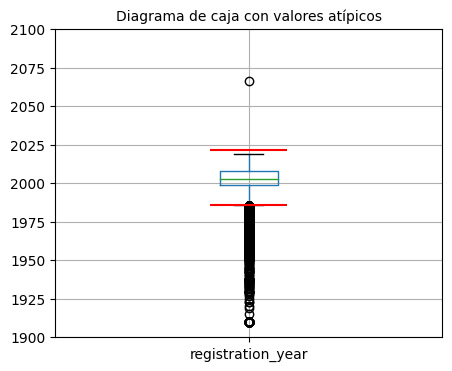

count    354107.000000
mean       2004.235355
std          90.261168
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [39]:
# Diagrama de caja para 'registration_year'
boxplot_function(df_auto, 'registration_year', (1900, 2100))

In [40]:
# Cálculo de límite inferior
Q1 = df_auto['registration_year'].quantile(0.25)
Q3 = df_auto['registration_year'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
print('Extremo inferior:', lower_bound, '\n')

total_count = len(df_auto['registration_year'])

for threshold in range(1900, 2001, 10):
    count_leq = (df_auto['registration_year'] <= threshold).sum()
    percentage = (count_leq / total_count) * 100
    print(f"Porcentaje de años <= {threshold}: {percentage:.2f}%")

Extremo inferior: 1985.5 

Porcentaje de años <= 1900: 0.02%
Porcentaje de años <= 1910: 0.05%
Porcentaje de años <= 1920: 0.05%
Porcentaje de años <= 1930: 0.05%
Porcentaje de años <= 1940: 0.06%
Porcentaje de años <= 1950: 0.07%
Porcentaje de años <= 1960: 0.17%
Porcentaje de años <= 1970: 0.47%
Porcentaje de años <= 1980: 1.14%
Porcentaje de años <= 1990: 3.52%
Porcentaje de años <= 2000: 35.77%


Considerando que el automóvil fue inventado en 1886 y que los datos disponibles abarcan hasta 2016, se seleccionarán únicamente los registros comprendidos entre 1970 y 2016. Aunque el límite inferior real de los datos es 1985, extender el corte hasta 1970 implica la eliminación de solo el 0.47% del total. Dado que no es posible imputar o predecir el año de matriculación a partir de otras variables, se procederá a filtrar el conjunto de datos con base en este rango temporal.

In [41]:
# Filtrado del dataset
df_filtered = df_auto.query('1970 <= registration_year <= 2016')

# Comprobación de cambios 
df_filtered['registration_year'].describe()

count    338241.000000
mean       2002.651858
std           6.465100
min        1970.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

In [42]:
# Conteo de observaciones eliminadas
print(f'Número de observaciones eliminadas: {(len(df) - len(df_filtered))}')

Número de observaciones eliminadas: 15866


### Price

Se registraron valores cero en la columna de precio de venta del vehículo, lo cual corresponde a vendedores que prefieren que el comprador los contacte directamente al no especificar un precio. Para evaluar la distribución de los datos y tomar una decisión informada, se aplicará la función boxplot_function sobre la columna de precios.

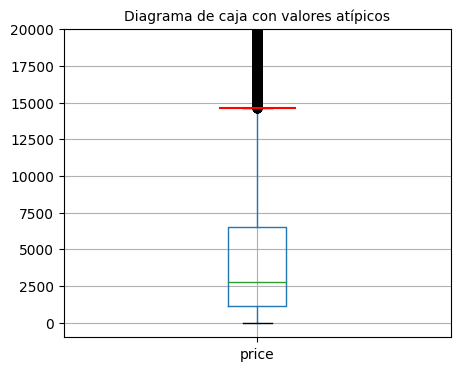

count    338241.000000
mean       4461.547784
std        4536.620100
min           0.000000
25%        1099.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [43]:
# Diagrama de caja para 'price'
boxplot_function(df_filtered, 'price', (-1000, 20000))

In [44]:
# Cálculo del porcentaje de datos por umbrales de precios
total_count = len(df_filtered['price'])

for threshold in range(100, 1101, 100):
    count_leq = (df_filtered['price'] <= threshold).sum()
    percentage = (count_leq / total_count) * 100
    print(f"Porcentaje de precios <= {threshold}: {percentage:.2f}%")

Porcentaje de precios <= 100: 3.92%
Porcentaje de precios <= 200: 5.39%
Porcentaje de precios <= 300: 7.24%
Porcentaje de precios <= 400: 9.11%
Porcentaje de precios <= 500: 11.74%
Porcentaje de precios <= 600: 14.11%
Porcentaje de precios <= 700: 16.40%
Porcentaje de precios <= 800: 18.94%
Porcentaje de precios <= 900: 21.13%
Porcentaje de precios <= 1000: 24.65%
Porcentaje de precios <= 1100: 25.79%


El diagrama de cajas muestra una asimetría positiva, atribuible al elevado número de valores cercanos a cero en el conjunto de datos. Para mejorar la calidad del modelo predictivo, se eliminarán los vehículos con precios inferiores o iguales a $100 (3.92%), ya que estos representan valores atípicos que podrían distorsionar el entrenamiento.

In [45]:
# Filtrado del dataset
df_filtered = df_filtered.query('100 <= price')

# Comprobación de cambios 
df_filtered['price'].describe() 

count    325995.000000
mean       4628.932640
std        4536.536986
min         100.000000
25%        1200.000000
50%        2950.000000
75%        6666.000000
max       20000.000000
Name: price, dtype: float64

In [46]:
# Conteo de observaciones eliminadas
print(f'Número de observaciones eliminadas: {(len(df) - len(df_filtered))}')

Número de observaciones eliminadas: 28112


### Power

Se analizaron los valores atípicos en la columna `power`, donde se registró un valor máximo de 20,000 HP y valores mínimos de 0 HP, cifras atípicas para la potencia en caballos de fuerza de vehículos. Para ello, se aplicó la función boxplot_function sobre dicha columna.

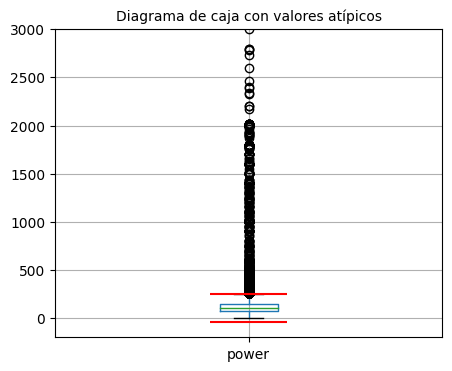

count    354107.000000
mean        110.089651
std         189.914972
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [47]:
# Diagrama de caja para 'power'
boxplot_function(df, 'power', (-200, 3000))

Al analizar el diagrama de cajas, se identifican valores atípicos cercanos a cero y por encima de 3,000 HP, considerando que la potencia mínima esperada para un vehículo es de 60 HP y la máxima alrededor de 1,800 HP. Se procederá a reemplazar con NaN todos los valores de potencia inferiores a 60 HP para su posterior análisis y posible imputación basada en otras variables. Por otro lado, se eliminarán los valores superiores a 2,000 HP, ya que representan valores extremos que podrían distorsionar el análisis.

In [48]:
# Filtrado del dataset
df_filtered = df_filtered.query('power <= 2000')

# Conversión de valores atípicos a Nan
df_filtered.loc[df_filtered['power'] < 50, 'power'] = np.nan

# Comprobación de cambios
df_filtered['power'].describe() 

count    289498.000000
mean        123.003437
std          62.679608
min          50.000000
25%          80.000000
50%         115.000000
75%         150.000000
max        2000.000000
Name: power, dtype: float64

In [49]:
# Conteo de valores atípicos y observaciones eliminadas
nan_power = df_filtered[df_filtered['power'].isna()]

print(f'Porcentaje de valores atípicos reemplazados por NaN: {(nan_power.shape[0] / len(df_filtered)) * 100:.2f}%')
print(f'Número de observaciones eliminadas: {(len(df) - len(df_filtered))}')

Porcentaje de valores atípicos reemplazados por NaN: 11.17%
Número de observaciones eliminadas: 28212


Se observa un alto porcentaje de valores extraños reemplazados por valores NaN; por tanto, se procederá a imputarlos según el modelo de vehículo.

In [50]:
# Filtrado de dataset sin valores ausentes en 'model' y 'pwoer', y creación de tabla dinámica que devuelva la mediana 
power_no_missing_values = df_filtered.dropna(subset=['power'])
power_model = power_no_missing_values.pivot_table(index=['model'], values='power', aggfunc='median')

# Función para llenado de valores faltantes
def fill_power(row):
    
    model = row['model']
    power = row['power']
    
    if pd.isna(power):
        try:
            return power_model.loc[model, 'power']
        except:
            return 'Error'
    return power

In [51]:
# Comprobación de funcionamiento correcto
row_values = [
    ['100', np.nan],
    ['falso', np.nan]
]
row_columns = ['model', 'power']
prueba_df = pd.DataFrame(data=row_values, columns=row_columns)
prueba_df = prueba_df.apply(fill_power, axis=1)
print(prueba_df)

0    133.0
1    Error
dtype: object


In [52]:
# Aplicación de la función
df_filtered['power'] = df_filtered.apply(fill_power, axis = 1)

# Comprobación de errores
df_filtered[df_filtered['power'] == 'Error']

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
234175,3800,wagon,1978,manual,Error,serie_1,30000,gasoline,land_rover,0


Uno de los valores de potencia presenta un dato faltante correspondiente al vehículo Land Rover serie 1. La potencia de este modelo es de 50 NP, por lo que se procederá a reemplazar el valor NaN con esta información verificada.

In [53]:
# Reemplazo y conversión de valores
df_filtered.loc[df_filtered['power'] == 'Error', 'power'] = 50
df_filtered['power'] = df_filtered['power'].astype('int')

# Comprobamos los resultados
print('Número de errores en power:', len(df_filtered[df_filtered['power'] == 'Error']), '\n')
print(df_filtered['power'].describe())

Número de errores en power: 0 

count    325895.000000
mean        120.831044
std          60.830407
min          50.000000
25%          75.000000
50%         110.000000
75%         147.000000
max        2000.000000
Name: power, dtype: float64


### Mileage

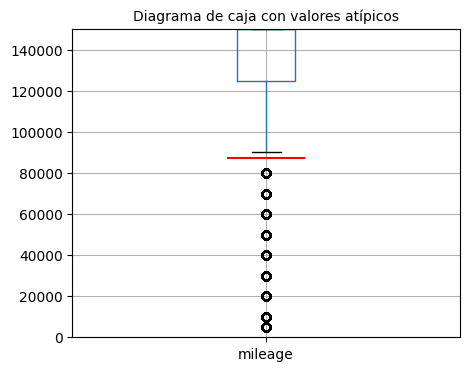

count    354107.000000
mean     128211.811684
std       37906.590101
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: mileage, dtype: float64

In [54]:
# Diagrama de caja para 'mileage'
boxplot_function(df, 'mileage', (0, 150000))

En relación con la variable 'mileage', se observa que los usuarios no proporcionan valores exactos, sino rangos aproximados; por ello, la variable no es continua, sino discreta.

In [55]:
# Conteo de frecuencias de valores
mileage_counts = df_filtered['mileage'].value_counts().sort_index()
print(mileage_counts)

mileage
5000        4284
10000       1011
20000       3606
30000       4146
40000       4708
50000       5904
60000       7132
70000       8177
80000       9513
90000      10929
100000     13755
125000     34174
150000    218556
Name: count, dtype: int64


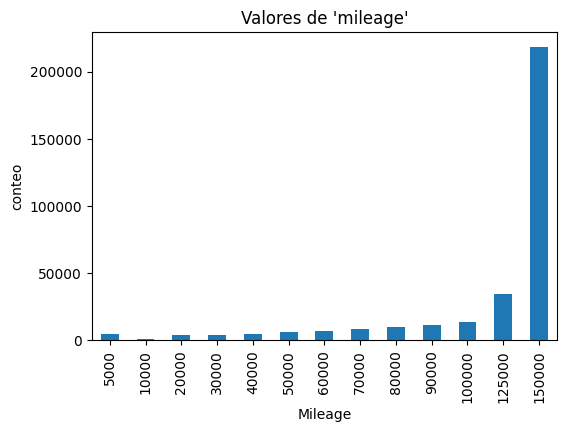

In [56]:
# Visualización de conteo de 'mileage'
mileage_counts.plot(kind='bar', figsize=(6, 4))

plt.xlabel('Mileage')
plt.ylabel('conteo')
plt.title("Valores de 'mileage'")
plt.show()

Aunque los valores inferiores a 100,000 se identifican como atípicos en el análisis, es posible que representen casos reales de vehículos con bajo uso. Por esta razón, se decidió conservar estos datos para mantener la integridad y representatividad del conjunto analizado, ya que podrían aportar información relevante sobre patrones de utilización poco frecuentes.

## Observaciones con valores desconocidos

Al completar las variables mediante distintos métodos, se identificaron casos en los que no fue posible asignar un valor adecuado, por lo que se etiquetaron como 'unknown'. Estos registros generan categorías artificiales que pueden introducir ruido y sesgar el modelo predictivo. Por esta razón, se optará por eliminar dichos casos para preservar la calidad y la integridad del análisis. 

In [57]:
# Búsqueda de observaciones con valores 'unknown'
rows_with_unknown = df_auto[df_auto.astype(str).apply(lambda col: col.str.contains('unknown', case=False)).any(axis=1)]
pctg = len(rows_with_unknown)/len(df_auto)
print("Observaciones con al menos un valor 'unknown':", len(rows_with_unknown), f", {pctg:.2f}%")

Observaciones con al menos un valor 'unknown': 6421 , 0.02%


In [58]:
# Filtrado de filas con valores 'unknown'
mask = (
    df_filtered['gearbox'].str.contains('unknown', case=False, na=False) |
    df_filtered['model'].str.contains('unknown', case=False, na=False) |
    df_filtered['vehicle_type'].str.contains('unknown', case=False, na=False) |
    df_filtered['fuel_type'].str.contains('unknown', case=False, na=False)
)

filtered_rows = df_filtered[mask]
display(filtered_rows.sample(3))

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
72467,2900,sedan,1980,unknown,118,other,150000,gasoline,bmw,0
300068,125,wagon,2000,unknown,109,focus,150000,gasoline,ford,0
4476,999,sedan,1990,unknown,118,other,30000,gasoline,mercedes_benz,0


Los datos depurados se almacenan en la variable denominada `df_final`, la cual servirá como base para la creación de los conjuntos de entrenamiento y prueba.

In [59]:
# Filtrado y copia de df con datos limpios
df_filtered = df_filtered.loc[~mask]

df_final = df_filtered.copy()

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321736 entries, 0 to 354106
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              321736 non-null  int64 
 1   vehicle_type       321736 non-null  object
 2   registration_year  321736 non-null  int64 
 3   gearbox            321736 non-null  object
 4   power              321736 non-null  int64 
 5   model              321736 non-null  object
 6   mileage            321736 non-null  int64 
 7   fuel_type          321736 non-null  object
 8   brand              321736 non-null  object
 9   not_repaired       321736 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 27.0+ MB


In [60]:
# Cálculo del porcentaje de datos mantenidos tras filtrado
print(f'Porcentaje mantenido: {((len(df_final)/len(df)) * 100):.2f}%')

Porcentaje mantenido: 90.86%


Utilizar solo el 90.86 % del conjunto de datos original tras la limpieza indica que se ha eliminado aproximadamente un 9.14 % de registros debido a valores faltantes, erróneos o atípicos. Esta reducción es común y necesaria para asegurar la calidad y fiabilidad del análisis, aunque es importante verificar que no se comprometa la representatividad ni se introduzca sesgo en el conjunto final. En caso de que la pérdida de datos sea significativa, se pueden considerar técnicas como la imputación o el tratamiento específico de valores atípicos para preservar la mayor cantidad de información posible sin afectar la integridad del análisis.

## Preparación de conjuntos de entrenamiento y prueba

Se crearán dos conjuntos de datos: uno únicamente escalado y otro escalado y codificado. Esta diferenciación responde a que algunos modelos de aprendizaje automático pueden trabajar directamente con variables categóricas, mientras que otros requieren que dichas variables estén codificadas numéricamente para su correcto procesamiento. En ambos casos, se aplicará escalado a los datos, ya que esta transformación mejora el rendimiento y la convergencia de los modelos en general. Posteriormente, cada conjunto se dividirá en subconjuntos de entrenamiento y prueba para evaluar adecuadamente el desempeño de los modelos.

In [61]:
# Conversión de columnas a tipo categórico
categorical = ['vehicle_type','gearbox', 'model','fuel_type','brand']
df_final[categorical] = df_final[categorical].astype('category')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321736 entries, 0 to 354106
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              321736 non-null  int64   
 1   vehicle_type       321736 non-null  category
 2   registration_year  321736 non-null  int64   
 3   gearbox            321736 non-null  category
 4   power              321736 non-null  int64   
 5   model              321736 non-null  category
 6   mileage            321736 non-null  int64   
 7   fuel_type          321736 non-null  category
 8   brand              321736 non-null  category
 9   not_repaired       321736 non-null  int64   
dtypes: category(5), int64(5)
memory usage: 16.6 MB


In [62]:
# Escalado de variables numéricas
df_sc = df_final.copy()
cols_to_scale = ['price', 'registration_year', 'power', 'mileage']

scaler = MaxAbsScaler()
df_sc[cols_to_scale] = scaler.fit_transform(df_sc[cols_to_scale])
df_sc.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,0.024,sedan,0.988591,manual,0.0505,golf,1.000000,gasoline,volkswagen,0
1,0.915,coupe,0.997520,manual,0.0950,a4,0.833333,gasoline,audi,1
2,0.490,suv,0.994048,auto,0.0815,grand,0.833333,gasoline,jeep,0
3,0.075,small,0.992560,manual,0.0375,golf,1.000000,gasoline,volkswagen,0
4,0.180,small,0.996032,manual,0.0345,fabia,0.600000,gasoline,skoda,0


In [63]:
# Codificación de variables categóricas

df_sc_cd = df_sc.copy()

# LabelEncoder para características con alta cardinalidad
le = LabelEncoder()
df_sc_cd['model_encoded'] = le.fit_transform(df_sc_cd['model'])
df_sc_cd['brand_encoded'] = le.fit_transform(df_sc_cd['brand'])
df_sc_cd.drop(columns=['model', 'brand'], inplace=True)

# OHE para características con baja cardinalidad
df_sc_cd = pd.get_dummies(df_sc_cd, columns=['vehicle_type', 'gearbox', 'fuel_type'], dtype=int)
display(df_sc_cd.head(5))

,price,registration_year,power,mileage,not_repaired,model_encoded,brand_encoded,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,...,vehicle_type_suv,vehicle_type_wagon,gearbox_auto,gearbox_manual,fuel_type_cng,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other
0,0.024,0.988591,0.0505,1.000000,0,116,37,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0.915,0.997520,0.0950,0.833333,1,29,1,0,0,1,...,0,0,0,1,0,0,1,0,0,0
2,0.490,0.994048,0.0815,0.833333,0,117,14,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,0.075,0.992560,0.0375,1.000000,0,116,37,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0.180,0.996032,0.0345,0.600000,0,101,31,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [64]:
# División de conjuntos escalados y codificados para modelado

# Conjuntos escalados
x_sc = df_sc.drop('price', axis=1)
y_sc = df_sc['price']

# Conjuntos escalados y codificados
x_sc_cd = df_sc_cd.drop('price', axis=1)
y_sc_cd = df_sc_cd['price']

# División en conjuntos de entrenamiento y prueba
x_train_sc_cd, x_test_sc_cd, y_train_sc_cd, y_test_sc_cd = train_test_split(x_sc_cd, y_sc_cd, test_size=0.25, random_state=12345)
x_train_sc, x_test_sc, y_train_sc, y_test_sc = train_test_split(x_sc, y_sc, test_size=0.25, random_state=12345)

# Comprobación de divisón correcta
print(f'Tamaño del conjunto de entrenamiento codificado: {x_train_sc_cd.shape}, {y_train_sc_cd.shape}')
print(f'Tamaño del conjunto de prueba codificado: {x_test_sc_cd.shape}, {y_test_sc_cd.shape}')

Tamaño del conjunto de entrenamiento codificado: (241302, 22), (241302,)
Tamaño del conjunto de prueba codificado: (80434, 22), (80434,)


# Comparación de modelos

## Regresión linear

El modelo de regresión lineal es una técnica estadística que establece una relación lineal entre una variable dependiente y una o varias variables independientes, permitiendo predecir valores continuos mediante una ecuación simple sin ajuste de hiperparámetros. Se utilizará como prueba de cordura para los modelos posteriores porque su simplicidad y ausencia de parámetros ajustables lo convierten en una referencia clara y sin sesgos de optimización. De este modo, el desempeño de los modelos más complejos podrá compararse objetivamente frente a este baseline, utilizando el error cuadrático medio (RECM) como métrica para evaluar si efectivamente aportan una mejora significativa.

In [65]:
# Entrenamiento del modelo de regresión lineal
start_train = time.time()
lr_model = LinearRegression()
lr_model.fit(x_train_sc_cd, y_train_sc_cd)
end_train = time.time()

# Predicciones
start_test = time.time()
y_pred = lr_model.predict(x_test_sc_cd)
end_test = time.time()

# Establecimiento de RECM (prueba de cordura)
RECM_lr = mean_squared_error(y_test_sc_cd, y_pred, squared=False)
time_train_lr = end_train - start_train
time_predict_lr = end_test - start_test

In [66]:
results = pd.DataFrame(columns=['recm', 'time_adj', 'time_train', 'time_pred'])
results.loc['Regresión Lineal (prueba  de cordura)'] = [RECM_lr, 0, time_train_lr, time_predict_lr]

results.round(4)

,recm,time_adj,time_train,time_pred
Regresión Lineal (prueba de cordura),0.1542,0.0,2.0243,0.0278


## Árbol de decisión

Un árbol de decisión es un modelo predictivo que representa decisiones y sus posibles resultados mediante una estructura jerárquica de nodos y ramas. Cada nodo interno evalúa una característica del conjunto de datos para dividirlo en subconjuntos más homogéneos, facilitando así tareas de clasificación o regresión. 

Para optimizar el desempeño del modelo, se explorarán los hiperparámetros `max_depth`, que controla la profundidad máxima del árbol para evitar sobreajuste; `min_samples_split`, que define el número mínimo de muestras necesarias para dividir un nodo; y `min_samples_leaf`, que establece el mínimo de muestras que debe tener una hoja. La búsqueda en los rangos `max_depth`, `min_samples_split` y `min_samples_leaf` 
permitirá encontrar la configuración que mejor balancee la complejidad y generalización del modelo.

In [67]:
# Establecimiento de hiperparámetros
params_dt = {
    'max_depth': [1, 2, 3, 4, 5, 6] ,
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8],
}

# Función GridSearchCV con hiperparámetros establecidos
dt_est = DecisionTreeRegressor(random_state=12345)

gridSearch_dt = GridSearchCV(
    estimator=dt_est,
    param_grid=params_dt,
    scoring='neg_root_mean_squared_error',
    cv=3   
)

In [68]:
# Entrenamiento de modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_dt.fit(x_train_sc_cd, y_train_sc_cd)
end = time.time()

time_adj_dt = end-start
print(f'Tiempo de ajuste de hiperparámetros para Árbol de Decisión: {time_adj_dt:.4f}s')

# Búsqueda de mejores hiperparámetros que devuelva el valor más bajo de RECM
max_score = gridSearch_dt.cv_results_['mean_test_score'].max()
index_max_score = np.where(gridSearch_dt.cv_results_['mean_test_score'] == max_score)[0][0]

best_set_of_params = gridSearch_dt.cv_results_['params'][index_max_score]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-max_score:.4f}')

Tiempo de ajuste de hiperparámetros para Árbol de Decisión: 176.0542s
Mejores hiperparámetros: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2} | Mejor RECM: 0.1139


In [69]:
# Entrenamiento del modelo con los mejores hiperparámetros 
start_train = time.time()
dt_model = DecisionTreeRegressor(random_state=12345, max_depth=6, min_samples_split=2, min_samples_leaf=2)
dt_model.fit(x_train_sc_cd, y_train_sc_cd)
end_train = time.time()

# Realización de predicciones con conjunto de prueba
start_test = time.time()
y_pred_dt = dt_model.predict(x_test_sc_cd)
end_test = time.time()

RECM_dt = mean_squared_error(y_test_sc_cd, y_pred_dt)**0.5

time_train_dt = end_train - start_train
time_predict_dt = end_test - start_test

In [70]:
# Visualización de resultados
results.loc['DecisionTreeRegressor'] = [RECM_dt, time_adj_dt, time_train_dt, time_predict_dt]
results.iloc[[0, -1]].round(4)

,recm,time_adj,time_train,time_pred
Regresión Lineal (prueba de cordura),0.1542,0.0000,2.0243,0.0278
DecisionTreeRegressor,0.1136,176.0542,1.7398,0.0215


## Bosque aleatorio

El bosque aleatorio es un algoritmo que combina múltiples árboles de decisión para mejorar la precisión y robustez de las predicciones. Cada árbol se construye a partir de una muestra aleatoria del conjunto de datos y considera un subconjunto aleatorio de características, lo que reduce la correlación entre árboles y minimiza el riesgo de sobreajuste. La predicción final se obtiene mediante el voto mayoritario en clasificación o el promedio en regresión, lo que aporta estabilidad y buen desempeño general. 

Para optimizar el modelo, se explorarán los hiperparámetros `'n_estimators'` —que determina la cantidad de árboles en el bosque— y `'max_depth'` —que limita la profundidad máxima de cada árbol. Esta búsqueda permitirá encontrar un balance adecuado entre complejidad y generalización, mejorando la capacidad predictiva del modelo.


In [71]:
# Establecimiento de hiperparámetros
params_rf = {
    'n_estimators' : [10, 20, 40],
    'max_depth': [4, 5, 6] 
}

#Función GridSearchCV con hiperparámetros establecidos
rf_est = RandomForestRegressor(random_state=12345)

gridSearch_rf = GridSearchCV(
    estimator=rf_est,
    param_grid=params_rf,
    scoring='neg_root_mean_squared_error',
    cv=3   
)

In [72]:
# Entrenamiento de modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_rf.fit(x_train_sc_cd, y_train_sc_cd)
end = time.time()

time_adj_rf = end-start

print(f'Tiempo de ajuste de hiperparámetros Bosque Aleatorio: {time_adj_rf:.4f}s')

# Búsqueda de mejores hiperparámetros que devuelva el valor más bajo de RECM
max_score = gridSearch_rf.cv_results_["mean_test_score"].max()
index_max_score = np.where(gridSearch_rf.cv_results_["mean_test_score"] == max_score)[0][0]

best_set_of_params = gridSearch_rf.cv_results_["params"][index_max_score]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-max_score:.4f}')

Tiempo de ajuste de hiperparámetros Bosque Aleatorio: 422.8277s
Mejores hiperparámetros: {'max_depth': 6, 'n_estimators': 40} | Mejor RECM: 0.1116


In [73]:
# Entrenamiento del modelo con los mejores hiperparámetros
start_train = time.time()
rf_model = RandomForestRegressor(random_state=12345, max_depth=6, n_estimators=40)
rf_model.fit(x_train_sc_cd, y_train_sc_cd)
end_train = time.time()

# Realización de predicciones con conjunto de prueba
start_test = time.time()
y_pred_rf = rf_model.predict(x_test_sc_cd)
end_test = time.time()

RECM_rf = mean_squared_error(y_test_sc_cd, y_pred_rf)**0.5

time_train_rf = end_train - start_train
time_predict_rf = end_test - start_test

In [74]:
# Visualización de resultados
results.loc['RandomForestRegresor'] = [RECM_rf, time_adj_rf, time_train_rf, time_predict_rf]
results.iloc[[0, -1]].round(4)

,recm,time_adj,time_train,time_pred
Regresión Lineal (prueba de cordura),0.1542,0.0000,2.0243,0.0278
RandomForestRegresor,0.1119,422.8277,48.9207,0.3637


## LightGBM

LightGBM es un algoritmo basado en el método de potenciación por gradiente (gradient boosting) que utiliza árboles de decisión para tareas de clasificación y regresión. Se destaca por su alta eficiencia y velocidad gracias a técnicas como el crecimiento de árboles por hojas, el uso de histogramas para agrupar datos y el muestreo unilateral basado en gradientes (GOSS), lo que permite manejar grandes volúmenes de datos con menor uso de memoria y mayor precisión. 

Para optimizar el desempeño del modelo, se explorarán los hiperparámetros clave: el número de estimadores (`n_estimators`), la tasa de aprendizaje (`learning_rate`), y el número de hojas (`num_leaves`). Ajustar estos parámetros permitirá encontrar un balance adecuado entre la complejidad del modelo y su capacidad de generalización, mejorando así la precisión en las predicciones.

In [75]:
# Establecimiento de hiperparámetros
params_lightgbm = {
    'n_estimators': [100, 300],
    'learning_rate': [0.1, 0.2, 0.5],
    'num_leaves': [10, 20]
}

# Función GridSearchCV con hiperparámetros establecidos
light_est = LGBMRegressor(verbosity=-1, random_state=12345)

gridSearch_lightgbm = GridSearchCV(
    estimator=light_est,
    param_grid=params_lightgbm,
    scoring='neg_root_mean_squared_error',
    cv=3  
)

In [76]:
# Entrenamiento de modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_lightgbm.fit(x_train_sc, y_train_sc)
end = time.time()

time_adj_light = end-start

print(f'Tiempo de ajuste de hiperparámetros para LightGBM: {time_adj_light:.4f}s')

# Búsqueda de mejores hiperparámetros que devuelva el valor más bajo de RECM 
max_score = gridSearch_lightgbm.cv_results_["mean_test_score"].max()
index_max_score = np.where(gridSearch_lightgbm.cv_results_["mean_test_score"] == max_score)[0][0]

best_set_of_params = gridSearch_lightgbm.cv_results_["params"][index_max_score]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-max_score:.4f}')

Tiempo de ajuste de hiperparámetros para LightGBM: 192.4546s
Mejores hiperparámetros: {'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 20} | Mejor RECM: 0.0792


In [77]:
# Entrenamiento del modelo con los mejores hiperparámetros
lightgbm_model = LGBMRegressor(learning_rate=0.2,
                               n_estimators=300, 
                               num_leaves=20,
                               random_state=12345)

start_train = time.time()
lightgbm_model.fit(x_train_sc, y_train_sc)
end_train = time.time()

# Realización de predicciones con conjunto de prueba
start_test = time.time()
y_pred_light = lightgbm_model.predict(x_test_sc)
end_test = time.time()

RECM_light = mean_squared_error(y_test_sc, y_pred_light)**0.5
time_train_light = end_train - start_train
time_pred_light = end_test - start_test

In [78]:
# Visualización de resultados
results.loc['LGBMRegressor'] = [RECM_light, time_adj_light, time_train_light, time_pred_light]
results.iloc[[0, -1]].round(4)

,recm,time_adj,time_train,time_pred
Regresión Lineal (prueba de cordura),0.1542,0.0000,2.0243,0.0278
LGBMRegressor,0.0784,192.4546,6.1948,1.3138


## CatBoost

CatBoost es un algoritmo de aprendizaje automático basado en la técnica de Gradient Boosting que destaca por su capacidad para manejar de forma eficiente variables categóricas sin necesidad de preprocesamiento previo, gracias a su innovador método de codificación ordenada. Esto permite construir modelos robustos y precisos para tareas de clasificación y regresión, optimizando tanto la velocidad como la calidad de las predicciones. 

Para optimizar el desempeño del modelo en este proyecto, se explorarán los hiperparámetros `'depth'` y `'learning_rate'`, buscando un balance adecuado entre complejidad del modelo y velocidad de convergencia que permita obtener resultados robustos y generalizables.

In [79]:
# Definición de características categóricas
cat_features = ['vehicle_type', 
                'gearbox', 
                'model', 
                'fuel_type', 
                'brand']

# Establecimiento de hiperparámetros
params_catboost = {
    'depth': [4, 6, 10],
    'learning_rate': [0.1, 0.2, 0.5]    
}

# Función GridSearchCV con hiperparámetros establecidos
catboost_est = CatBoostRegressor(iterations=100, cat_features=cat_features, verbose=False, loss_function='RMSE', random_seed=12345)

gridSearch_catboost = GridSearchCV(
    estimator=catboost_est,
    param_grid=params_catboost,
    scoring='neg_root_mean_squared_error',
    cv=3  
)

In [80]:
# Entrenamiento de modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_catboost.fit(x_train_sc, y_train_sc)
end = time.time()
time_adj_cat = end-start

print(f'Tiempo de ajuste de hiperparámetros para CatBoost: {time_adj_cat:.4f}s')

# Búsqueda de mejores hiperparámetros que devuelva el valor más bajo de RECM 
max_score = gridSearch_catboost.cv_results_["mean_test_score"].max()
index_max_score = np.where(gridSearch_catboost.cv_results_["mean_test_score"] == max_score)[0][0]

best_set_of_params = gridSearch_catboost.cv_results_["params"][index_max_score]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-max_score:.4f}')

Tiempo de ajuste de hiperparámetros para CatBoost: 374.1526s
Mejores hiperparámetros: {'depth': 10, 'learning_rate': 0.5} | Mejor RECM: 0.0811


In [81]:
# Entrenamiento del modelo con los mejores hiperparámetros
catboost_model = CatBoostRegressor(iterations=100, 
                                  depth=10,
                                  learning_rate=0.5,
                                  loss_function='RMSE',
                                  random_seed=12345)

start_train = time.time()
catboost_model.fit(x_train_sc, y_train_sc, cat_features=cat_features, verbose=False)
end_train = time.time()

# Realización de predicciones con conjunto de prueba
start_test = time.time()
y_pred_cat = catboost_model.predict(x_test_sc)
end_test = time.time()

RECM_catboost = mean_squared_error(y_test_sc, y_pred_cat)**0.5
time_train_cat = end_train - start_train
time_pred_cat = end_test - start_test

In [82]:
# Visualización de resultados
results.loc['CatBoost'] = [RECM_catboost, time_adj_cat, time_train_cat, time_pred_cat]
results.iloc[[0, -1]].round(4)

,recm,time_adj,time_train,time_pred
Regresión Lineal (prueba de cordura),0.1542,0.0000,2.0243,0.0278
CatBoost,0.0799,374.1526,35.9880,0.3123


## XGBoost

XGBoost (eXtreme Gradient Boosting) es un algoritmo avanzado de aprendizaje supervisado que combina múltiples árboles de decisión para mejorar la precisión mediante la técnica de optimización de gradiente. Este método construye secuencialmente árboles que corrigen los errores de los anteriores, optimizando tanto la precisión como la eficiencia computacional. 

Para optimizar su desempeño en este proyecto, se explorarán los hiperparámetros clave: la profundidad máxima de los árboles (`max_depth`), la tasa de aprendizaje (`learning_rate`), y el número de árboles (`n_estimators`) con valores. Explorar estos parámetros permitirá encontrar un balance adecuado entre complejidad del modelo, velocidad de aprendizaje y capacidad de generalización.

In [83]:
# Establecimiento de hiperparámetros
params_xgboost = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators': [50, 100]
}

# Función GridSearchCV con hiperparámetros establecidos
xboost_est = XGBRegressor(random_state=12345)

gridSearch_xboost = GridSearchCV(
    estimator=xboost_est,
    param_grid=params_xgboost,
    scoring='neg_root_mean_squared_error',
    cv=3  
)

In [84]:
# Entrenamiento de modelo para encontrar los mejores hiperparámetros
start = time.time()
gridSearch_xboost.fit(x_train_sc_cd, y_train_sc_cd)
end = time.time()

time_adj_xgboost = end-start

print(f'Tiempo de ajuste de hiperparámetros para XGBoost: {time_adj_xgboost:.4f}s')

# Búsqueda de mejores hiperparámetros que devuelva el valor más bajo de RECM 
max_score = gridSearch_xboost.cv_results_["mean_test_score"].max()
index_max_score = np.where(gridSearch_xboost.cv_results_["mean_test_score"] == max_score)[0][0]

best_set_of_params = gridSearch_xboost.cv_results_["params"][index_max_score]

print(f'Mejores hiperparámetros: {best_set_of_params} | Mejor RECM: {-max_score:.4f}')

Tiempo de ajuste de hiperparámetros para XGBoost: 209.3908s
Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100} | Mejor RECM: 0.0795


In [85]:
# Entrenamiento del modelo con los mejores hiperparámetros
xgboost_model = XGBRegressor(random_state=12345, 
                             max_depth=8, 
                             learning_rate= 0.2,
                             n_estimators= 100)

start_train = time.time()
xgboost_model.fit(x_train_sc_cd, y_train_sc_cd)
end_train = time.time()

# Realización de predicciones con conjunto de prueba
start_test = time.time()
y_pred_xgboost = xgboost_model.predict(x_test_sc_cd)
end_test = time.time()

RECM_XGBoost = mean_squared_error(y_test_sc_cd, y_pred_xgboost)**0.5

time_train_xgboost = end_train - start_train
time_pred_xgboost = end_test - start_test

In [86]:
# Visualización de resultados
results.loc['XGBoost'] = [RECM_XGBoost, time_adj_xgboost, time_train_xgboost, time_pred_xgboost]
results.iloc[[0, -1]].round(4)

,recm,time_adj,time_train,time_pred
Regresión Lineal (prueba de cordura),0.1542,0.0000,2.0243,0.0278
XGBoost,0.0790,209.3908,5.7506,0.3328


## Conclusiones de sección

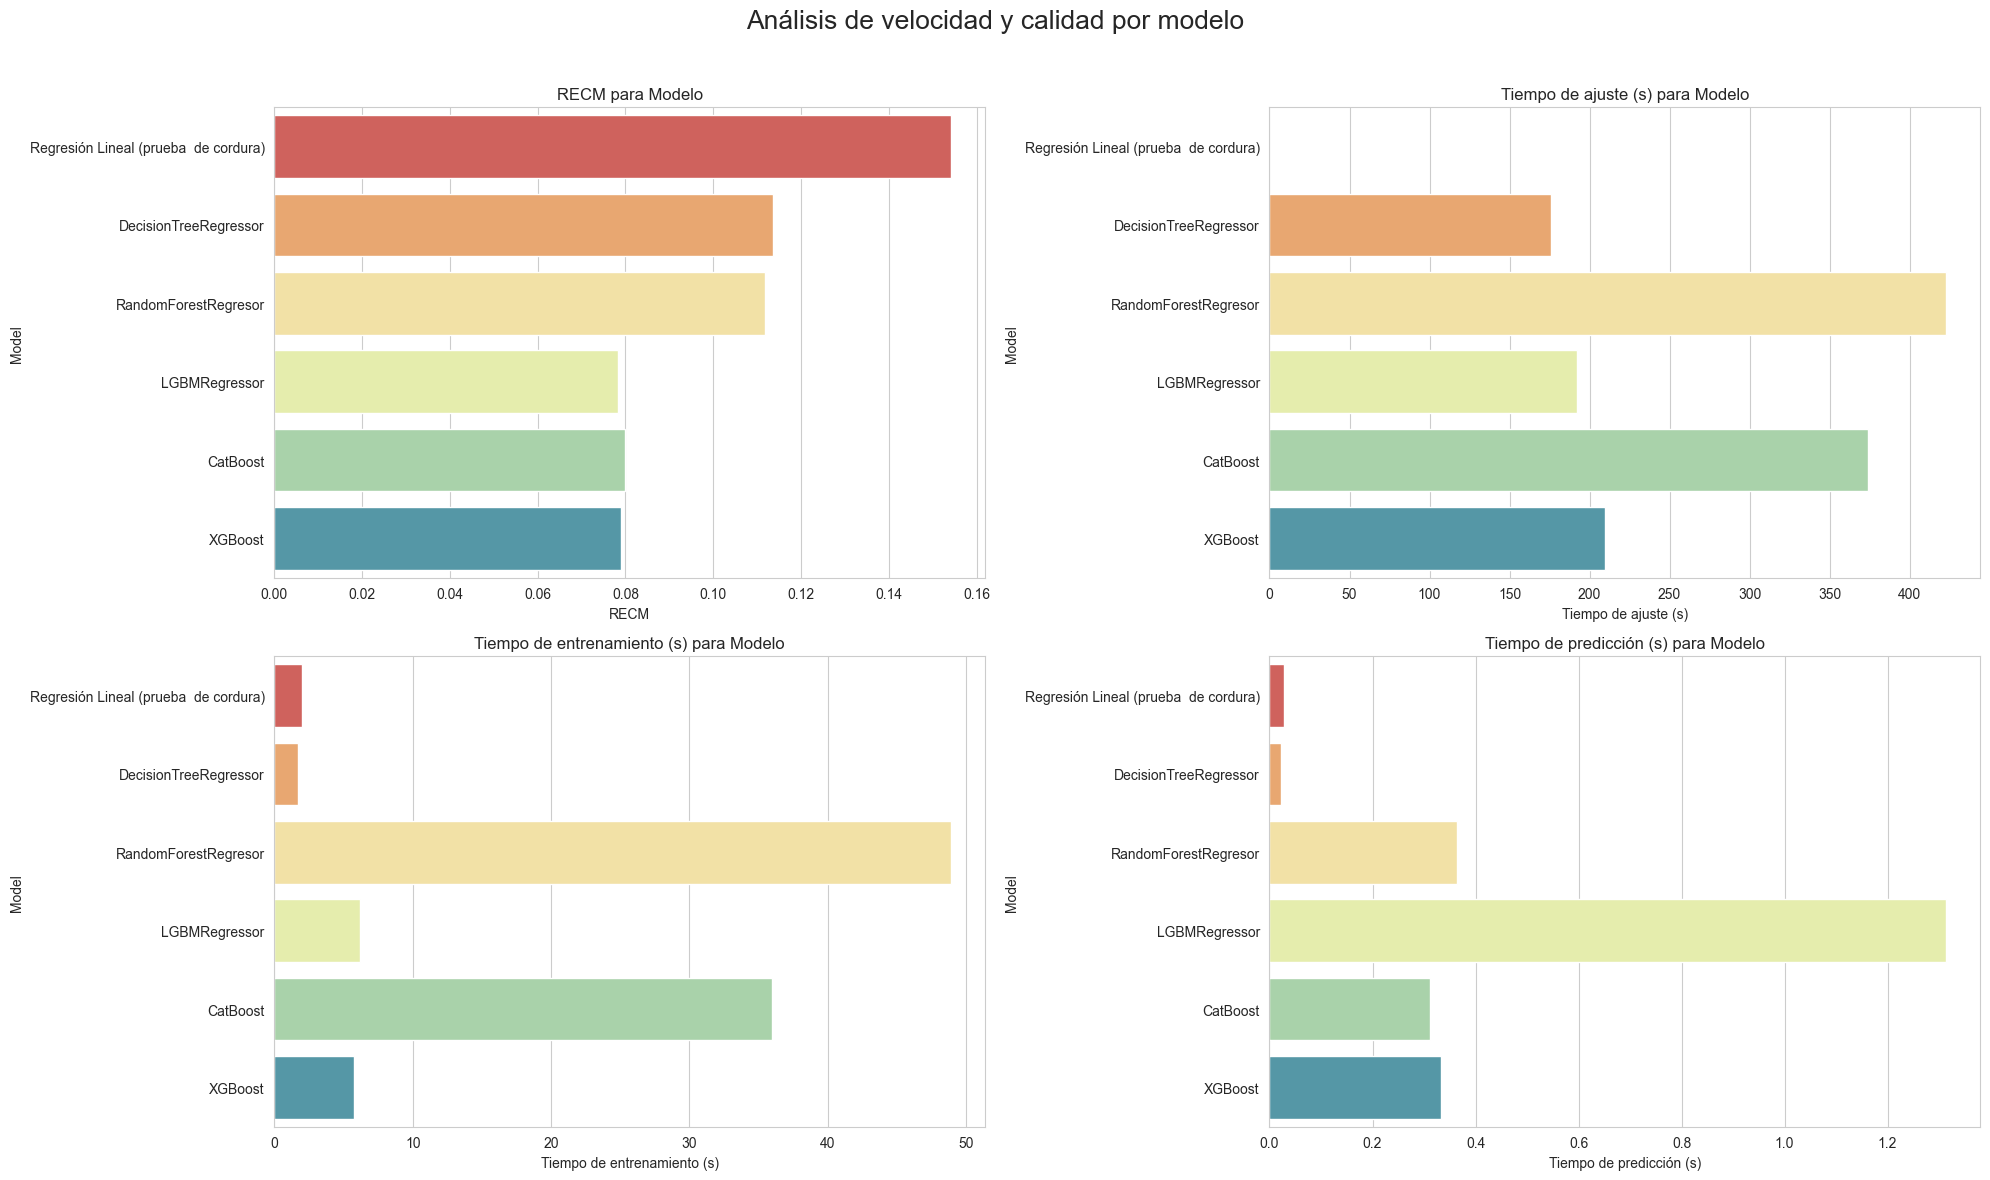

In [87]:
# Visualización comparativa de velocidad y calidad de modelos de aprendizaje automático
table = results.copy()
table.columns = ['RECM', 'Tiempo de ajuste (s)', 'Tiempo de entrenamiento (s)', 'Tiempo de predicción (s)']

sns.set_style('whitegrid')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
axes = axes.flatten()

# Reset index to have model names as a column
df_plot = table.reset_index().rename(columns={'index': 'Model'})

for n, col in enumerate(['RECM', 'Tiempo de ajuste (s)', 'Tiempo de entrenamiento (s)', 'Tiempo de predicción (s)']):
    ax = axes[n]
    # Use y='Model' and x=metric column
    # Assign hue='Model' to use palette without warning, disable legend to avoid clutter
    sns.barplot(x=col, y='Model', data=df_plot, ax=ax, palette="Spectral", hue='Model', dodge=False, legend=False)
    ax.set_xlabel(col)
    ax.set_ylabel('Model')
    ax.set_title(f'{col} para Modelo')

plt.suptitle('Análisis de velocidad y calidad por modelo', fontsize=19)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


In [88]:
# Suma de columnas para calcular tiempo total (entrenamiento + predicción)
results['time_total'] = results[['time_train', 'time_pred']].sum(axis=1)
results

,recm,time_adj,time_train,time_pred,time_total
Regresión Lineal (prueba de cordura),0.154200,0.000000,2.024272,0.027811,2.052083
DecisionTreeRegressor,0.113581,176.054169,1.739787,0.021542,1.761329
RandomForestRegresor,0.111888,422.827675,48.920748,0.363733,49.284482
LGBMRegressor,0.078375,192.454577,6.194831,1.313752,7.508583
CatBoost,0.079935,374.152643,35.987968,0.312268,36.300236
XGBoost,0.079000,209.390797,5.750574,0.332751,6.083325


*Calidad de predicción (RECM):*

- Los modelos basados en boosting (**LightGBM, CatBoost, XGBoost**) lideran en precisión, con RECM alrededor de 0.078-0.08, seguidos muy de cerca por RandomForest (0.1119). La regresión lineal y el árbol de decisión tienen errores más altos (0.1542 y 0.1136 respectivamente), lo que indica menor calidad predictiva.

*Tiempos de entrenamiento y predicción:*

- Regresión lineal es extremadamente rápida en entrenamiento y predicción, aunque su calidad es la peor.

- DecisionTreeRegressor tiene un tiempo de entrenamiento alto (176 s) pero predicción rápida (1.74 s).

- RandomForest y CatBoost tienen tiempos de entrenamiento y predicción elevados, especialmente RandomForest con casi 49 s en total.

-  LightGBM y XGBoost ofrecen un buen balance: tiempos moderados (7.5 s y 6.08 s total) con la mejor calidad predictiva.


In [89]:
# Normalización de métricas 
recm_norm = (results['recm'] - results['recm'].min()) / (results['recm'].max() - results['recm'].min())
time_norm = (results['time_total'] - results['time_total'].min()) / (results['time_total'].max() - results['time_total'].min())

# Cálculo de índice compuesto para selección de modelo óptimo
results['indice_compuesto'] = recm_norm + time_norm
display(results.round(4))

print(f"El modelo con mejor relación RECM-tiempo es: {results.index[results['indice_compuesto'].argmin()]}")

,recm,time_adj,time_train,time_pred,time_total,indice_compuesto
Regresión Lineal (prueba de cordura),0.1542,0.0000,2.0243,0.0278,2.0521,1.0061
DecisionTreeRegressor,0.1136,176.0542,1.7398,0.0215,1.7613,0.4643
RandomForestRegresor,0.1119,422.8277,48.9207,0.3637,49.2845,1.4420
LGBMRegressor,0.0784,192.4546,6.1948,1.3138,7.5086,0.1209
CatBoost,0.0799,374.1526,35.9880,0.3123,36.3002,0.7474
XGBoost,0.0790,209.3908,5.7506,0.3328,6.0833,0.0992


El modelo con mejor relación RECM-tiempo es: XGBoost


Se utilizó el índice compuesto como un parámetro que otorga igual importancia a la calidad de la predicción y a la eficiencia en tiempo, permitiendo así evaluar el desempeño global de cada modelo de manera equilibrada. Este índice se interpreta de forma sencilla: entre menor es su valor, mejor es el balance entre precisión y rapidez. Por ejemplo, valores bajos como los de XGBoost (0.0992) y LightGBM (0.1209) indican modelos que logran alta precisión manteniendo tiempos razonables de entrenamiento y predicción. En contraste, valores altos como los de RandomForest (1.4420) y regresión lineal (1.0061) reflejan un peor equilibrio, ya sea por menor calidad predictiva o por tiempos excesivos. **Gracias a este criterio, se concluyó que XGBoost es el modelo más eficiente y preciso, seguido muy de cerca por LightGBM.**

# Conclusiones finales

- Se realizó la inicialización e importación de librerías especializadas para análisis, visualización y modelado de datos, asegurando un entorno robusto y modular para el desarrollo del proyecto.

- El conjunto de datos original contenía 16 columnas y 354,369 registros; tras una selección cuidadosa, se redujo a 10 columnas relevantes para la valoración de vehículos, eliminando variables irrelevantes y facilitando el análisis posterior.

- Durante la exploración de datos se identificaron valores ausentes en cinco variables categóricas y 262 registros duplicados, ambos aspectos tratados para mejorar la calidad y fiabilidad del dataset.

- La visualización de datos permitió detectar la predominancia de ciertas categorías como el tipo sedán, la transmisión manual y la marca Volkswagen, así como la necesidad de unificar categorías redundantes (por ejemplo, “petrol” y “gasoline”).

- El análisis estadístico reveló alta variabilidad en precios y presencia de valores atípicos en variables numéricas como precio, año de registro y potencia, lo que motivó un tratamiento específico para evitar distorsiones en el modelo.

- En el procesamiento de datos se estandarizaron nombres de columnas, se eliminaron duplicados, se imputaron valores ausentes y se abordaron los valores atípicos, asegurando así un conjunto de datos limpio y coherente para el modelado.

- Se compararon diversos modelos de machine learning, evaluando tanto la calidad de la predicción como la eficiencia en tiempo de entrenamiento y predicción mediante un índice compuesto que pondera ambos aspectos por igual.

- Los modelos XGBoost y LightGBM destacaron por su excelente balance entre precisión y eficiencia, con índices compuestos bajos (0.0992 y 0.1209 respectivamente), siendo **XGBoost el modelo seleccionado como el mejor para predecir el valor de mercado de los vehículos.**